# Unit Commitment Problem

## Initialisation

In [13]:
from IPython import get_ipython
get_ipython().magic('reset -sf')


from gurobipy import *
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import datetime
import xlrd
import pandas as pd
import math
import time
import datetime
import os
import time

## Import Data

In [14]:
cluster =  0
num_regions = 1
current_year = 2017

test_run = 2

t0 = time.time()



### Generator Data

In [15]:
df_summary = pd.read_csv("SUMMARY.csv")

x = df_summary.columns.values

# Import all of the data from the df
label = df_summary['REF'].values

gen_type = df_summary['TYPE'].values

age = current_year - df_summary['AGE'].values

capacity = df_summary['TOTAL UK CAPACITY'].values

min_power_ref = df_summary['MINIMUM OUTPUT'].values
min_power = min_power_ref * capacity

max_power_out_ref = df_summary['MAXIMUM OUTPUT'].values
max_power_out = max_power_out_ref * capacity

max_ramp_up_ref = df_summary['MAX RAMP UP'].values
max_ramp_up = max_ramp_up_ref * capacity

max_ramp_down_ref = df_summary['MAX RAMP DOWN'].values
max_ramp_down = max_ramp_down_ref * capacity

startup_ramp_ref = df_summary['MAX RAMP UP'].values
startup_ramp = startup_ramp_ref * capacity

shutdown_ramp_ref = df_summary['MAX RAMP DOWN'].values
shutdown_ramp = shutdown_ramp_ref * capacity

initial_status = df_summary['INITIAL STATUS'].values

# Variables below are for the unit commitment constraints
prior_status_up = df_summary['PRIOR STATUS UP'].values

prior_status_down = df_summary['PRIOR STATUS DOWN'].values

up_time_prior = df_summary['PRIOR UP TIME'].values

down_time_prior = df_summary['PRIOR DOWN TIME'].values

min_up = df_summary['MIN UP TIME'].values

min_down = df_summary['MIN DOWN TIME'].values

# op_type = df_summary['OP TYPE'].values

# Set up variables for the storage
storage_capacity = df_summary['STORAGE CAPACITY'].values

batt_eff = df_summary['BATT EFFICIENCY'].values

duration = df_summary['MAX STORAGE HOURS'].values

# Read in the generator names
gen_names = numpy.unique(gen_type)
num_types = range(0,len(gen_names))

# The num_gen variable specifies the total number of generators available in the mix
num_gen = range(0, len(max_power_out))



# df_summary

### Cost Data

In [26]:
df_costs = pd.read_csv("COST.csv")

x = df_costs.columns.values

# Fixed O&M - £/kW-yr in - with conversion £/MWh
# CHECKED
fixed_om = df_costs['FIXED O_M'].values * (1000/8760)

# Variable O&M - £/MWh
# CHECKED
variable_om = df_costs['VARIABLE O_M'].values

# Capital Cost - £/kW-yr
# CHECKED
capital_cost = df_costs['CAPITAL COST'].values * (1000/8760)

# Fixed Cost - £/kW-yr
# CHECKED
fixed_cost = df_costs['FIXED'].values  * (1000/8760)

# Heat during start up - MBTU/start
startup_heat = df_costs['START UP HEAT'].values

# Fixed cost for startup - £/start
startup_fixed = df_costs['FIXED COST START'].values

# No load heat - MBTU/h
no_load_heat = df_costs['NO LOAD HEAT'].values

# Incremental heat rate - BTU/kWh - equivalent to MBTU/MWh
incr_heat_rate = (df_costs['INCREMENTAL HEAT RATE'].values)/1000

# Fixed cost for shut-down - £/shut
shutdown_cost = df_costs['FIXED COST SHUT'].values

# Read in the fuel cost £/MBTU
fuel_cost = df_costs['FUEL COST'].values

# df_costs


In [27]:
months = ["Jan"]

# , "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"

len_months = range(len(months))
years = ["11"]

# , "12", "13", "14", "15", "16"

len_years = range(len(years))

for j in len_years:
    for z in len_months:
        demandname = str("DemandData"+str(years[j])+"_"+str(months[z])+".csv")
        pricename = str("GBPriceData"+str(years[j])+"_"+str(months[z])+".csv")
        


### Total Demand Data

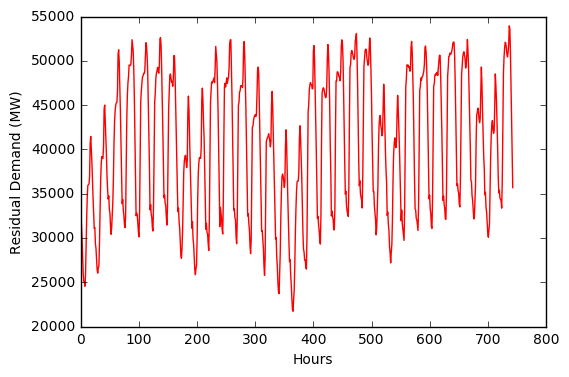

In [28]:
        df_demand = pd.read_csv(str(demandname))
        x = df_demand.columns.values

        numpyMatrix = df_demand.as_matrix()

        national_demand = df_demand['ND'].values
        national_demand = national_demand[1::2]
        wind_gen = df_demand['EMBEDDED_WIND_GENERATION'].values
        wind_gen = wind_gen[1::2]
        solar_gen = df_demand['EMBEDDED_SOLAR_GENERATION'].values
        solar_gen = solar_gen[1::2]
        french_flow = df_demand['FRENCH_FLOW'].values
        french_flow = french_flow[1::2]
        britned_flow = df_demand['BRITNED_FLOW'].values
        britned_flow = britned_flow[1::2]
        moyle_flow = df_demand['MOYLE_FLOW'].values
        moyle_flow  = moyle_flow [1::2]
        eastwest_flow = df_demand['EAST_WEST_FLOW'].values
        eastwest_flow = eastwest_flow[1::2]
        hours = range(len(national_demand))

        demand = national_demand - wind_gen - solar_gen - french_flow - britned_flow - moyle_flow - eastwest_flow

        reserve = 0.1 * demand

        plt.figure()
        plt.plot(hours, demand, 'r')
        plt.xlabel('Hours')
        plt.ylabel('Residual Demand (MW)')
        plt.show()
        
        # Number of hours
        max_hours = len(hours)




In [29]:
        df_price = pd.read_csv(str(pricename), decimal=',')

        x = df_price.columns.values

        price = df_price['PRICE'].values

        plt.figure()
        plt.plot(hours, price, 'r')
        plt.xlabel('Hours')
        plt.ylabel('Price (£/MWh)')
        plt.show()

OSError: File b'GBPriceData11_Jan.csv' does not exist

## Clustering

### By Type - Single Bus Model

In [79]:
        # This code takes the imported data for all of the available generators, and summarises it into the clustered sets

        df_cluster = pd.read_csv("REFERENCE LIST.csv")
        df_cluster_cost = pd.read_csv("REFERENCE_LIST_COST.csv")

        gen_label = df_cluster['TYPE'].values
        num_labels = range(0,len(gen_label))

        if cluster == 1:

            capacity_clustered = df_cluster['CAPACITY'].values
            capacity_clustered = numpy.nan_to_num(capacity_clustered)

            for i in num_gen:
                for x in num_labels:
                    a = gen_type[i]
                    b = gen_label[x]
                    if a in b:
                        capacity_clustered[x] = capacity_clustered[x] + capacity[i] 

            # Replace capacity with the new clustered capacity value
            capacity = capacity_clustered 

            min_power_ref = df_cluster['MINIMUM OUTPUT'].values
            min_power = min_power_ref * capacity

            max_power_out_ref = df_cluster['MAXIMUM OUTPUT'].values
            max_power_out = max_power_out_ref * capacity

            max_ramp_up_ref = df_cluster['MAX RAMP UP'].values
            max_ramp_up = max_ramp_up_ref * capacity

            max_ramp_down_ref = df_cluster['MAX RAMP DOWN'].values
            max_ramp_down = max_ramp_down_ref * capacity

            startup_ramp_ref = df_cluster['MAX RAMP UP'].values
            startup_ramp = startup_ramp_ref * capacity

            shutdown_ramp_ref = df_cluster['MAX RAMP DOWN'].values
            shutdown_ramp = shutdown_ramp_ref * capacity

            initial_status = df_cluster['INITIAL STATUS'].values

            # Variables below are for the unit commitment constraints
            #prior_status_up = df_cluster['PRIOR STATUS UP'].values

            prior_status_down = df_cluster['PRIOR STATUS DOWN'].values

            #up_time_prior = df_cluster['PRIOR UP TIME'].values

            down_time_prior = df_cluster['PRIOR DOWN TIME'].values

            min_up = df_cluster['MIN UP TIME'].values

            min_down = df_cluster['MIN DOWN TIME'].values

            # Set up variables for the storage
            storage_capacity = df_cluster['STORAGE CAPACITY'].values

            batt_eff = df_cluster['BATT EFFICIENCY'].values

            duration = df_cluster['MAX STORAGE HOURS'].values

            op_type = df_cluster['OP TYPE'].values

            # Num_types is the number of types of generators available
            num_types = num_labels

            # The num_gen variable specifies the total number of generators available in the mix
            num_gen = range(0, len(max_power_out))

            # Number of hours
            max_hours = len(hours)

            # Fixed O&M - £/kW-yr

            fixed_cost = df_cluster_cost['FIXED O_M'].values

            # Variable O&M - £/MWh
            variable_cost = df_cluster_cost['VARIABLE O_M'].values

            # Capital Cost - £/kW-yr
            capital_cost = df_cluster_cost['CAPITAL COST'].values

            # Fixed Cost - £/kW-yr
            fixed_cost_ops = df_cluster_cost['FIXED_COST OPS'].values

            # Heat during start up - MBTU/start
            startup_heat = df_cluster_cost['START UP HEAT'].values

            # Fixed cost for startup - £/start
            startup_fixed = df_cluster_cost['FIXED COST START'].values

            # No load heat - MBTU/h
            no_load_heat = df_cluster_cost['NO LOAD HEAT'].values

            # Incremental heat rate - BTU/kWh
            incr_heat_rate = df_cluster_cost['INCREMENTAL HEAT RATE'].values

            # Fixed cost for shut-down - £/shut
            shutdown_cost = df_cluster_cost['FIXED COST SHUT'].values

            fuel_cost = df_cluster_cost['FUEL COST'].values

            gen_type = gen_label



## Generate the model & set up the key variables

In [80]:
g = [0]*(len(max_power_out))
l = [0]*(len(max_power_out))  
        
for i in num_gen:
    g[i] = min(max_hours, max(0, ((min_up[i] - up_time_prior[i]) * initial_status[i])))
    
for i in num_gen:
    l[i] = min(max_hours, max(0, ((min_down[i] - down_time_prior[i]) * (1 - initial_status[i]))))

In [81]:
# Generate the model
model = Model("UnitCommitment")

# Power output variable
p = model.addVars(hours, num_gen, vtype=GRB.CONTINUOUS, name="p")

# Upper Power limit variable
p_upper = model.addVars(hours, num_gen, vtype=GRB.CONTINUOUS, name="p_upper")

# Unit commitment binary variable for thermal generators
v = model.addVars(hours, num_gen, vtype=GRB.BINARY, name="v")

# Discharging of battery (level of discharge)
discharge = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="discharging")

discharge_status = model.addVars(hours, num_gen, vtype=GRB.BINARY, name="discharge_status")

# Charging of battery (level of charge)
charge = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="charging")

charge_status = model.addVars(hours, num_gen, vtype=GRB.BINARY, name="charge_status")

# Storage level of the battery
energy = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="stored_energy")

# New capacity variable
new_capacity = model.addVars(num_gen, vtype = GRB.CONTINUOUS, name="new capacity")

# Start up cost

startupcost = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="startupcost")

# Shut down cost

shutdowncost = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="shutdowncost")

# Operating & Maintenance cost

omcost = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="operating_maintenance")

# Energy cost

energycost = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="energy")

# Fixed cost

fixed = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="fixed")

# Variable cost

variable = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="variable")

## Key Model Constraints

### Balance demand and generation

\begin{equation}
\sum\limits_{j \in J}^{} {{p_j}(k) = D(k)}
\end{equation}

\begin{equation}
\sum\limits_{j \in J}^{} {{{\overline p }_j}(k) \ge D(k) + R(k)}
\end{equation}

In [83]:
# Balance Constraint
count = 0
for hour in hours:
    label = ["balance_"+str(count)]
    label = str(label)
    model.addConstr((quicksum(p[hour, i] for i in num_gen) + (quicksum(discharge[hour, i] for i in num_gen)) >= demand[hour] + quicksum(charge[hour, i] for i in num_gen)), name=label)
    count = count + 1

# Spinning Reserve Constraint
count = 0
for hour in hours:
    label = ["reserve_"+str(count)]
    label = str(label)
    model.addConstr((quicksum(p_upper[hour,i] for i in num_gen) + (quicksum(discharge[hour, i] for i in num_gen)) >= demand[hour] + quicksum(charge[hour, i] for i in num_gen) + reserve[hour]), name=label)       
    count = count + 1 


\begin{equation}
\underline {{P_j}} {v_j}(k) \le {p_j}(k) \le \overline {{p_j}} (k)
\end{equation}

In [84]:
# Range constraint for power output
for hour in hours:
    for i in num_gen:
            model.addConstr((p[hour,i] <= p_upper[hour,i]), name="power_range_upper")
                       
for hour in hours:
    for i in num_gen:
            model.addConstr((p[hour,i] >= v[hour,i] * (min_power[i] + (min_power_ref[i] * new_capacity[i]))), name="power_range_lower")
        
        

\begin{equation}
0 \le \overline {{p_j}} (k) \le \overline {{P_j}} {v_j}(k)
\end{equation}

In [85]:
# Range constraint for power output
for hour in hours: 
    for i in num_gen:
            model.addConstr((p_upper[hour,i] <= v[hour,i] * (max_power_out[i] + (max_power_out_ref[i] * new_capacity[i]))), name="upper_power_limit_upper")
            
for hour in hours: 
    for i in num_gen:
            model.addConstr((p_upper[hour,i] >= 0), name="upper_power_limit_lower")

 
            
            


## Thermal Generator Constraints

### Maximum power output based on ramp-up and start-up rates 

\begin{equation}
\overline {{p_j}} (k) \le {p_j}(k - 1) + R{U_j}{v_j}(k - 1) + S{U_j}[{v_j}(k) - {v_j}(k - 1)]
\end{equation}

In [86]:
# Ramp-Up Constraint
for hour in hours:
    if hour == 0:
        for i in num_gen:
                model.addConstr((p_upper[hour, i] <= p[0,i] + 
                             (max_ramp_up[i] + (max_ramp_up_ref[i]*new_capacity[i])) * prior_status_up[i] + 
                                startup_ramp[i]*(v[hour, i] - prior_status_up[i] )), name="power_ramp_up")
    else: 
        for i in num_gen:
                model.addConstr((p_upper[hour, i] <= p[hour-1, i] + 
                             (max_ramp_up[i] + (max_ramp_up_ref[i]*new_capacity[i])) * v[hour-1, i] + 
                                startup_ramp[i]*(v[hour, i] - v[hour-1, i] )), name="power_ramp_up")

### Maximum power output based on ramp-down and shut down rates

\begin{equation}
\overline {{p_j}} (k) \le \overline {{P_j}} {v_j}(k + 1) + S{D_j}[{v_j}(k) - {v_j}(k + 1)]
\end{equation}

In [87]:
# Ramp-Down Constraint
for hour in hours:
    if hour < max(hours):
        for i in num_gen:
                model.addConstr((p_upper[hour,i] <= (max_power_out[i] + (max_power_out_ref[i] * new_capacity[i])) * v[hour + 1, i] + 
                 shutdown_ramp[i] * (v[hour, i] - v[hour + 1, i])), name="power_ramp_down_one")

\begin{equation}
{p_j}(k - 1) - {p_j} (k) \le   R{D_j}{v_j}(k) + S{D_j}[{v_j}(k - 1) - {v_j}(k)] + \overline {{P_j}} [1 - {v_j}(k - 1)]
\end{equation}

In [88]:
for hour in hours:
    if hour == 0:
        for i in num_gen:
                model.addConstr((p[0,i] - p[hour,i] <=  (max_ramp_down[i] + (max_ramp_down_ref[i] * new_capacity[i])) * v[hour, i] + 
                shutdown_ramp[i] * (prior_status_up[i] - v[hour,i]) + 
                p_upper[hour, i] * (1 - prior_status_up[i])), name="power_ramp_down_two")
                
    else:
        for i in num_gen:
                model.addConstr((p[hour-1,i] - p[hour,i] <=  (max_ramp_down[i] + (max_ramp_down_ref[i] * new_capacity[i])) * v[hour, i] + 
                shutdown_ramp[i] * (v[hour-1,i] - v[hour,i]) + 
                p_upper[hour, i] * (1 - v[hour-1, i])), name="power_ramp_down_two")


### Minimum Up-time Constraints

\begin{equation}
\sum\limits_{k = 1}^{{G_j}} {[1 - {v_j}(k)] = 0} 
\end{equation}

In [89]:
for i in num_gen:
    if g[i] > 0:
        hour_range = range(g[i])
        for hour in hour_range:
                model.addConstr((quicksum(1 - v[hour,i] for hour in hour_range) == 0 ), name="min_up_time_1")

\begin{equation}
\sum\limits_{n = k}^{k + U{T_j} - 1} {{v_j}(n)}  \ge U{T_j}[{v_j}(k) - {v_j}(k - 1)]
\end{equation}

In [90]:
for i in num_gen:
        # hour range int is the range of values over which the sums will be completed, i.e g[i] = first k value, g[i]+UT[i] - 1
        # is the last value
    hour_range_int = range(g[i], max(hours) - min_up[i] - 1)
    
    # complete the check on each of the variables in the set above
    for hour in hour_range_int:
            # create the range over which the individual sums will occur
        hour_temp = range(hour, hour + min_up[i] - 1)
        for j in hour_temp:
            
                # if the first of the range values is 0, i.e if g[i] = 0
            if g[i] == 0:
                model.addConstr((quicksum(v[j, i] for j in hour_temp) >= min_up[i] * (v[hour, i]-prior_status_up[i])), name="min_up_time_2")
                # if the first of the range values is > 0 i.e if g[i] > 0
            else:
                model.addConstr((quicksum(v[j, i] for j in hour_temp) >= min_up[i] * (v[hour, i] - v[hour-1, i])), name="min_up_time_2")

               

\begin{equation}
\sum\limits_{n = k}^T {\{ {v_j}(n) - [{v_j}(k) - {v_j}(k - 1)]\} }  \ge 0
\end{equation}

In [91]:
for i in num_gen:
        #    print(min_up[i])
        # note just changed the below to be referencing a different location - i.e min_up[i] instead of min_up[i] - 1
    hour_range_int = range(max(hours) - min_up[i] , max(hours))
    #    print(hour_range_int)
    for hour in hour_range_int:
        hour_temp = range(hour, max(hours))
#        print(hour_temp)
        for j in hour_temp:
            model.addConstr((quicksum(v[j,i] - (v[hour, i] - v[hour - 1, i])for j in hour_temp) >= 0), name="min_up_time_3")

### Minimum Down-time Constraint

\begin{equation}
\sum\limits_{k = 1}^{{L_j}} {{v_j}(k) = 0} 
\end{equation}

In [92]:
for i in num_gen:
#    if gen_type[i] != 'Battery':
    if l[i] > 0:
        hour_range = range(l[i])
        for hour in hour_range:
            model.addConstr((quicksum(v[hour,i] for hour in hour_range) == 0 ), name="min_down_time_1")

\begin{equation}
\sum\limits_{n = k}^{k + D{T_j} - 1} {[1 - {v_j}(n)]}  \ge D{T_j}[{v_j}(k - 1) - {v_j}(k)]
\end{equation}

In [93]:
for i in num_gen:
        # hour range int is the range of values over which the sums will be completed, i.e g[i] = first k value, g[i]+UT[i] - 1
        # is the last value
    hour_range_int = range(l[i], max(hours) - min_down[i] - 1)
    
        # complete the check on each of the variables in the set above
    for hour in hour_range_int:
            # create the range over which the individual sums will occur
        hour_temp = range(hour, hour + min_down[i] - 1)
        for j in hour_temp:
            
                # if the first of the range values is 0, i.e if g[i] = 0
            if l[i] == 0:
                model.addConstr((quicksum(1 - v[j, i] for j in hour_temp) >= min_down[i] * (prior_status_down[i] - v[hour, i])), name="min_down_time_2")
                    # if the first of the range values is > 0 i.e if g[i] > 0
            else:
                model.addConstr((quicksum(1 - v[j, i] for j in hour_temp) >= min_down[i] * (v[hour-1, i] - v[hour, i])), name="min_down_time_2")

        
                

\begin{equation}
\sum\limits_{n = k}^T {\{ 1 - {v_j}(n) - [{v_j}(k - 1) - {v_j}(k)]\} }  \ge 0
\end{equation}

In [94]:
for i in num_gen:
    hour_range_int = range(max(hours) - min_down[i], max(hours))
    for hour in hour_range_int:
        hour_temp = range(hour, max(hours))
        for j in hour_temp:
            model.addConstr((quicksum(1 - v[j,i] - (v[hour - 1, i] - v[hour, i]) for j in hour_temp) >= 0), name="min_down_time_3")

## Storage Unit Constraints

### Battery storage

\begin{equation}
s_{jk}^ +  v_{jk}  \le \overline {{s_{jk}}} 
\end{equation}

\begin{equation}
s_{jk}^ -  \le \overline {{s_{jk}}} 
\end{equation}

In [95]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Pumped hydro':
            model.addConstr((discharge[hour, i]  <= (storage_capacity[i] + new_capacity[i]) * discharge_status[hour, i]), name="discharge11")
            model.addConstr((discharge[hour, i]  >= ((storage_capacity[i] + new_capacity[i]) * 0.1 * discharge_status[hour, i])), name="discharge21") 
            model.addConstr((charge[hour, i] <= (storage_capacity[i] + new_capacity[i]) * charge_status[hour, i]), name="charge11")
            model.addConstr((charge[hour, i] >= (storage_capacity[i] + new_capacity[i]) * 0.1 * charge_status[hour, i]), name="charge21")
            model.addConstr((v[hour, i] == 0), name="battery_unit_commit1")    

\begin{equation}
es_i^t \le \overline {{s_i}} \cdot sc_{i}
\end{equation}

In [96]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Pumped hydro':
            model.addConstr((energy[hour, i] <= (storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr1")
            model.addConstr((energy[hour, i] >= 0.5*(storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr21")

\begin{equation}
es_i^t = es_i^{t - 1} - s_{ti}^ +  + {\eta _{si}} \cdot s_{ti}^ - 
\end{equation}

In [97]:
for i in num_gen:
    for hour in hours:
        if hour > 0:
            if gen_type[i] == 'Pumped hydro':
                model.addConstr((energy[hour, i] == energy[hour - 1, i] - discharge[hour, i] + 
                                 (batt_eff[i] * charge[hour, i])), name = "storage_levels1")

### Pumped Storage

In [98]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Battery':
            model.addConstr((discharge[hour, i]  <= (storage_capacity[i] + new_capacity[i]) * discharge_status[hour, i]), name="discharge12")
            model.addConstr((discharge[hour, i]  >= ((storage_capacity[i] + new_capacity[i]) * 0.1 * discharge_status[hour, i])), name="discharge22") 
            model.addConstr((charge[hour, i] <= (storage_capacity[i] + new_capacity[i]) * charge_status[hour, i]), name="charge12")
            model.addConstr((charge[hour, i] >= (storage_capacity[i] + new_capacity[i]) * 0.1 * charge_status[hour, i]), name="charge22")
            model.addConstr((v[hour, i] == 0), name="battery_unit_commit2")

In [99]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Battery':
            model.addConstr((energy[hour, i] <= (storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr2")
            model.addConstr((energy[hour, i] >= 0.5*(storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr22")

In [100]:
for i in num_gen:
    for hour in hours:
        if hour > 0:
            if gen_type[i] == 'Battery':
                model.addConstr((energy[hour, i] == energy[hour - 1, i] - discharge[hour, i] + 
                                 (batt_eff[i] * charge[hour, i])), name = "storage_levels2")
                

### General Constraints for Storage Variables

In [101]:
if cluster == 1:
    for i in num_gen:
        for hour in hours:
             if op_type[i] == 'THERMAL':
                model.addConstr((discharge[hour, i] == 0), name="discharge31")
                model.addConstr((charge[hour, i] == 0), name="charge31")
                model.addConstr((energy[hour, i] == 0), name="energyconstr32")
                

                
# Note I have added this to ensure that the soln will solve - need to enter a more robust answer though 
if cluster == 0:
    for i in num_gen:
        for hour in hours:
            model.addConstr((discharge[hour, i] == 0), name="discharge31")
            model.addConstr((charge[hour, i] == 0), name="charge31")
            model.addConstr((energy[hour, i] == 0), name="energyconstr32")

In [102]:
# Ensure that the units cannot be both charging and discharging at the same time
for i in num_gen:
    for hour in hours:
            model.addConstr((discharge_status[hour, i] + charge_status[hour, i] <= 1), name="charge_discharge_limit")

## Constraints for new capacity

In [103]:
for i in num_gen:
    # Set the new capacity to ensure that it does not install more than 100% of it's currently installed amount
    model.addConstr((new_capacity[i] == 0), name="newcapacity")
    

## Objective Function

\begin{equation}
\min \sum\limits_{k \in K}^{} {\sum\limits_{j \in J}^{} {c_j^{generation}(k) + c_j^{cycling}(k)} } 
\end{equation}

### Generation Cost

\begin{equation}
c_j^{generation}(k) = c_j^{O\& M}(k) + \,c_j^{energy}(k)\, + \,\,c_j^{fixed}(k)\,\,\,\,\,\,\,\,\,\,\forall  k \in K,\,\forall  j  \in J
\end{equation}

\begin{equation}
c_j^{energy}(k) = c_j^{no - load}(k)\,\, + \,\,c_j^{incr.heat - rate}(k)
\end{equation}

In [104]:
# Cost of generating the power - no load heat + incremental heat rates
for hour in hours:
    for i in num_gen:
        model.addConstr(energycost[hour,i] == (no_load_heat[i] * fuel_cost[i] * v[hour, i]) + (incr_heat_rate[i] * p[hour, i]), name="energycost1") 

        
# Ensure that the formulae returns only positive values
#for hour in hours:
#    for i in num_gen:
#        model.addConstr(energycost[hour,i] >= 0, name="energycost2")

\begin{equation}
c_j^{O\& M}(k) = c_j^{fixed - O\& M}(k) + c_j^{{\mathop{\rm var}} iable - O\& M}
\end{equation}

In [105]:
# Calculate the operating cost of the facility                                                                                                              
for hour in hours:
    for i in num_gen:
        model.addConstr(omcost[hour, i] == (fixed_om[i]*capacity[i]) + (variable_om[i]*p[hour, i]), name="opcost1")
        
#for hour in hours:
#    for i in num_gen:
#        model.addConstr(omcost[hour, i] >= 0, name="opcost2")

\begin{equation}
c_j^{fixed}(k)\,\, = \pi _j^{fixed} \times {G_j}
\end{equation}

In [106]:
for hour in hours:
    for i in num_gen:
        model.addConstr(fixed[hour, i] == fixed_cost[i] * capacity[i], name="fixedcost1")
          
#for hour in hours:
#    for i in num_gen:
#        model.addConstr(fixed[hour, i] >= 0, name="fixedcost2")


### Cycling Cost 

\begin{equation}
c_j^{cycling}(k) = c_j^{start - up}(k) + c_j^{shut - down}(k)
\end{equation}

\begin{equation}
c_j^{shut - down}(k) = \pi _j^{shut - down\,(fixed)}(k)\,\, \times \,\,\,[{v_j}(k - 1) - {v_j}(k)]\\
c_j^{shut - down}(k) \ge 0
\end{equation}

In [107]:
hour_range = range(1, max(hours))

# Calculate the shut down cost based on the number of shut-downs the facility goes through
for hour in hour_range:
    for i in num_gen:
        model.addConstr(shutdowncost[hour, i] >= shutdown_cost[i] * (v[hour -1, i] - v[hour, i]), name="shutdowncost1")
        
for hour in hour_range:
    for i in num_gen:
        model.addConstr(shutdowncost[hour, i] >= 0, name="shutdowncost2")    

# By setting the first hour start up/shut down cost to zero it will allocate the optimum configuration of generation assets on/off
# but will not see the expense of switching them all on initially
for i in num_gen:
    model.addConstr(shutdowncost[0, i] == 0, name="shutdowncost3")

\begin{equation}
c_j^{start - up}(k) = \pi _j^{start - up\,(fixed)}(k)\, + x_j^{fuel - start} \times \pi _j^{fuel} \times \,\,\,[{v_j}(k) - {v_j}(k - 1)]\,\,\,\,\,\forall  k \in K,\,\forall  j  \in J\\
c_j^{start - up}(k) \ge 0\,\,\,\,\,\forall  k \in K,\,\forall  j  \in J\\
c_j^{start - up}(0) = 0\,\,\,\,\,\forall  j  \in J
\end{equation}

In [108]:
# Calculate the start up cost of the facility
for hour in hour_range:
    for i in num_gen:
        model.addConstr(startupcost[hour, i] >= (startup_fixed[i] + (startup_heat[i] * fuel_cost[i])) * (v[hour, i] - v[hour - 1, i]), name="startupcost1")
        
        
for hour in hour_range:
    for i in num_gen:
         model.addConstr(startupcost[hour, i] >= 0, name="startupcost2")


# By setting the first hour start up/shut down cost to zero it will allocate the optimum configuration of generation assets on/off
# but will not see the expense of switching them all on initially
for i in num_gen:
    model.addConstr(startupcost[0, i] == 0, name="startupcost3")

In [109]:
# Set the objective function

productioncost = quicksum(quicksum(energycost[hour, i] + omcost[hour, i] + shutdowncost[hour, i] + startupcost[hour, i] + fixed[hour, i] for i in num_gen)for hour in hours)

obj = productioncost 

model.setObjective(obj, GRB.MINIMIZE)



In [110]:
# Run the optimisation code

model.Params.timeLimit = 500
model.optimize()
status = model.status  


Changed value of parameter timeLimit to 500.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 2343950 rows, 1322959 columns and 27596437 nonzeros
Model has 475162 quadratic constraints
Variable types: 1039495 continuous, 283464 integer (283464 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+04]
  QMatrix range    [1e-01, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 2086053 rows and 876487 columns (presolve time = 6s) ...
Presolve removed 2122810 rows and 960357 columns (presolve time = 12s) ...
Presolve removed 2122810 rows and 960357 columns
Presolve time: 11.65s
Presolved: 648697 rows, 433777 columns, 1963656 nonzeros
Variable types: 214990 continuous, 218787 integer (79444 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2648856e+09   4.049867e+07   0.000000e+00     14s
   36203    1.4374463e+09   3.30

In [111]:
# Output Results if necessary

if status == 2 or 9:
    sol_p = model.getAttr("X", p)
    sol_v = model.getAttr("X", v)
    sol_p_upper = model.getAttr("X", p_upper)
    sol_charging = model.getAttr("X",charge)
    sol_discharging = model.getAttr("X",discharge)
    sol_batt_level = model.getAttr("X",energy)
    sol_charge_up = model.getAttr("X",charge_status)
    sol_discharge_up = model.getAttr("X",discharge_status)
    sol_new_capacity = model.getAttr("X", new_capacity)
    sol_energycost = model.getAttr("X", energycost)
    sol_opcost = model.getAttr("X", omcost)
    sol_fixedcost = model.getAttr("X", fixed)
    sol_startcost = model.getAttr("X", startupcost)
    sol_shutcost = model.getAttr("X", shutdowncost)
    
    
#    print('Optimization status was %d' % status)
#    print('The optimal objective is %g' % model.objVal)



# Post Process

## Graphs

### Data processing

In [112]:
from numpy import inf

# gen_type_summary is the variable that stores all of the clustered results (when using the unclustered data - i.e all
# individual generators - i.e when cluster == 0)
gen_type_summary = np.zeros((len(num_types), len(hours)))

power_stack = np.zeros((len(num_types), len(hours)))

# Each of these variables stores the results from the model - this needs to be checked to figure out if it needs to be this way
# i.e are there other ways of just using the output variables?

power_out = np.matlib.zeros((len(hours), len(max_power_out)))

unit_com = np.matlib.zeros((len(hours), len(max_power_out)))

power_upper_res = np.matlib.zeros((len(hours), len(max_power_out)))

total_gen = np.matlib.zeros((len(hours), 1))

total_res = np.matlib.zeros((len(hours), 1))

opcost = np.matlib.zeros((len(hours), len(num_gen)))

energycost = np.matlib.zeros((len(hours), len(num_gen)))

startcost = np.matlib.zeros((len(hours), len(num_gen)))

shutdowncost = np.matlib.zeros((len(hours), len(num_gen)))

total_opcost = np.matlib.zeros((len(hours), 1))

total_energycost = np.matlib.zeros((len(hours), 1))

total_startcost = np.matlib.zeros((len(hours), 1))

total_shutdowncost = np.matlib.zeros((len(hours), 1))

total_cost = np.matlib.zeros((len(hours), 1))

total_unit_cost = np.matlib.zeros((len(hours), 1))

totalMWh = np.matlib.zeros((len(num_gen),1))

totalhours = np.matlib.zeros((len(num_gen),1))

loadfactor = np.matlib.zeros((len(hours), len(num_gen)))

avgloadfactor = np.matlib.zeros((len(num_gen),1))

utility =  np.matlib.zeros((len(num_gen),1))

discharging = np.matlib.zeros((len(hours), len(num_gen)))

charging = np.matlib.zeros((len(hours), len(num_gen)))

charge_up = np.matlib.zeros((len(hours), len(num_gen)))

discharge_up = np.matlib.zeros((len(hours), len(num_gen)))

batt_level = np.matlib.zeros((len(hours), len(num_gen)))

new_install = np.matlib.zeros((len(num_gen),1))

total_system_cost = np.matlib.zeros((len(hours), 1))

batt_level = np.matlib.zeros((len(hours), len(num_gen)))

total_cost_pergen = np.matlib.zeros((len(hours), len(num_gen)))

energycostpergen = np.matlib.zeros((len(hours), len(num_gen)))

opcostpergen = np.matlib.zeros((len(hours), len(num_gen)))

fixedcost = np.matlib.zeros((len(hours), len(num_gen)))

for hour in hours:
    for i in num_gen:
        power_out[hour, i] = sol_p[hour,i]
        unit_com[hour, i] = sol_v[hour,i]
        power_upper_res[hour, i] = sol_p_upper[hour, i]
        discharging[hour, i] = sol_discharging[hour, i]
        charging[hour, i] = sol_charging[hour, i]
        batt_level[hour, i] = sol_batt_level[hour, i]
        charge_up[hour, i] = sol_charge_up[hour, i]
        discharge_up[hour, i] = sol_discharge_up[hour, i]
        opcost[hour, i] = sol_opcost[hour, i]
        energycost[hour, i] = sol_energycost[hour, i]
        startcost[hour, i] = sol_startcost[hour, i]
        shutdowncost[hour, i] = sol_shutcost[hour, i]
        fixedcost[hour, i] = sol_fixedcost[hour, i]

        
# Calculate the total costs
total_opcost = numpy.sum(opcost, axis=1)
total_energycost = numpy.sum(energycost, axis=1)
total_startcost = numpy.sum(startcost, axis=1)
total_shutdowncost = numpy.sum(shutdowncost, axis=1)
total_cost = total_opcost + total_energycost + total_startcost + total_shutdowncost

# Calculate the total generation and reserve
total_gen = numpy.sum(power_out, axis=1)
total_res = numpy.sum(power_upper_res, axis=1)

# Process the data for each individual generator
for i in num_gen:
    for hour in hours:
        loadfactor[hour, i] = power_out[hour, i] / max_power_out[i]
        # Calculate the marginal price per generator
        total_cost_pergen[hour, i] = (energycost[hour, i] + opcost[hour, i] + startcost[hour, i] + shutdowncost[hour, i])/power_out[hour, i]
        energycostpergen[hour, i] = (energycost[hour, i])/power_out[hour, i]
        opcostpergen[hour, i] = (opcost[hour, i])/power_out[hour, i]
    loadfactor = numpy.nan_to_num(loadfactor) 
    totalMWh[i] = sum(power_out[:,i])
    totalhours[i] = sum(unit_com[:, i])
    avgloadfactor[i] = sum(loadfactor[:, i]) / totalhours[i]
    avgloadfactor = numpy.nan_to_num(avgloadfactor) 
    utility[i] = totalhours[i]/len(hours)
    new_install[i] = sol_new_capacity[i]
    
# Remove all nan and inf values from matrix
total_cost_pergen[total_cost_pergen == inf] = 0
location = np.isnan(total_cost_pergen)
total_cost_pergen[location] = 0

# marginal price derivation

max_cost = np.matlib.zeros((len(hours), 1))
max_op_cost = np.matlib.zeros((len(hours), 1))
max_energy_cost = np.matlib.zeros((len(hours), 1))
reference = np.matlib.zeros((len(hours), 1))
marginal_price = np.matlib.zeros((len(hours), 1))
ref_array = np.matlib.zeros((1, len(num_gen)))

for hour in hours:
#    ref_array = total_cost_pergen[hour,:]
    reference= np.argmax(total_cost_pergen[hour,:])
    a = int(round(reference))
#    reference
    max_cost[hour] = total_cost_pergen[hour, a]
    max_op_cost[hour] = opcost[hour, a]/power_out[hour, a]
    max_energy_cost[hour] = energycost[hour, a]/power_out[hour, a]
#    marginal_price[hour] = max_cost[hour]/power_out[hour, reference[hour]]
    
for hour in hours:
    total_unit_cost[hour] = total_cost[hour]/demand[hour]
    
# Process the data in terms of the generating types
# This code is for the unclustered set
if cluster == 0:
    for i in num_gen:
        for x in num_labels:
                a = gen_type[i]
                b = gen_label[x]
                if a in b:
                    gen_type_summary[x,:] = gen_type_summary[x,:] + np.transpose(power_out[:,i])
                    
                
              
# This code is for the clustered set 
if cluster == 1:
    for i in num_types:
        power_stack[i,:] = np.transpose(power_out[:,i])

### Hourly Pricing

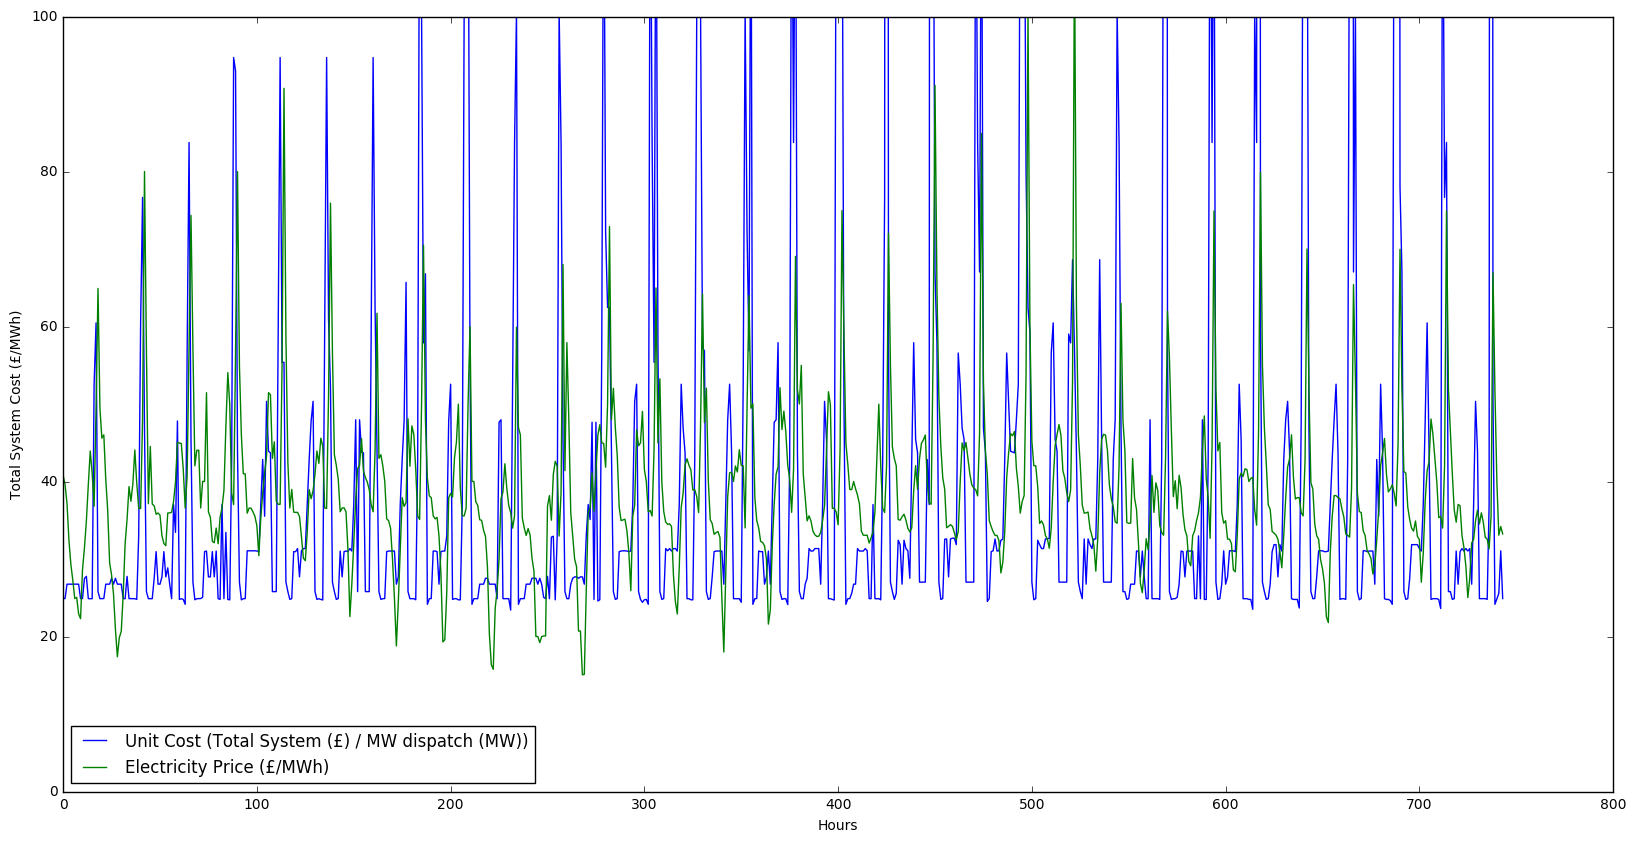

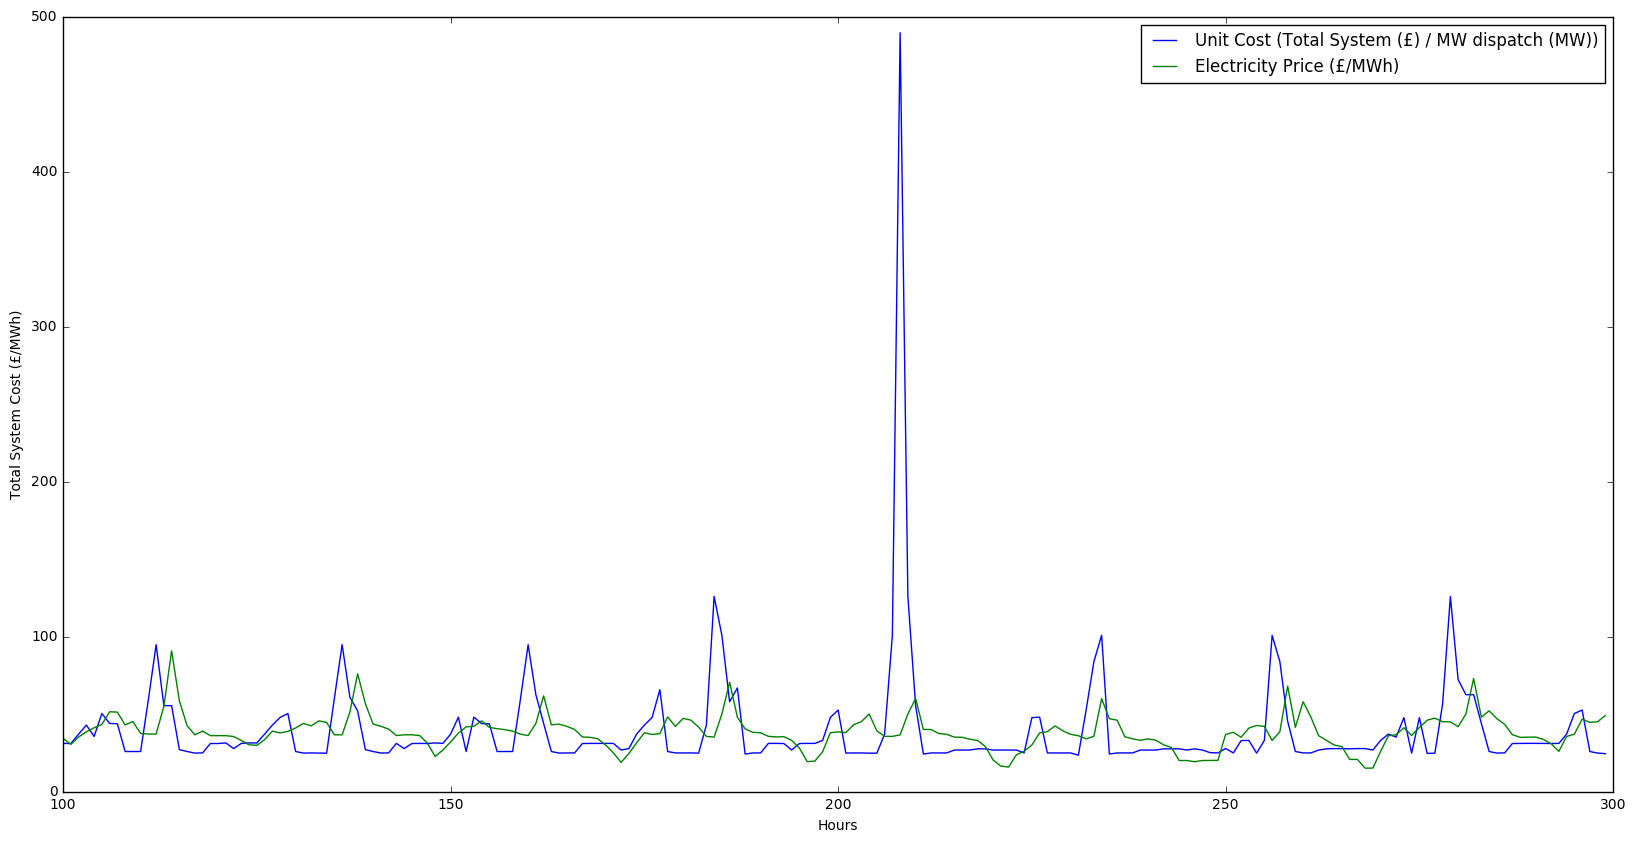

In [113]:

        
hourslimited = hours[100:300]
unitcostlimited = total_unit_cost[0:40]
totalgenlimited = total_gen[0:40]
pricelimited = price[100:300]
maxcostlimited = max_cost[100:300]

total_opcost_limited = total_opcost[0:40]
total_energycost_limited = total_energycost[0:40]
total_startcost_limited = total_startcost[0:40]
total_shutdowncost_limited = total_shutdowncost[0:40]
total_cost_limited = total_cost[0:100]
demandlimited = demand[0:100]
pricelimited = price[100:300]
xlimited = total_system_cost[0:100]

fig = plt.figure(figsize=(20, 10), dpi=100)
plt.plot(hours,max_cost, 'b', label='Unit Cost (Total System (£) / MW dispatch (MW))')
#plt.plot(hours, max_op_cost, 'r', label='Op Cost')
#plt.plot(hours, max_energy_cost, label='Energy Cost' )
plt.plot(hours, price, 'g', label='Electricity Price (£/MWh)')
plt.xlabel('Hours')
plt.ylabel('Total System Cost (£/MWh)')
plt.ylim((0,100))
plt.legend(loc='best')
fig.savefig('170701_pricecomparison_total.png')   # save the figure to file
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(20, 10), dpi=100)
plt.plot(hourslimited,maxcostlimited, 'b', label='Unit Cost (Total System (£) / MW dispatch (MW))')
#plt.plot(hours, max_op_cost, 'r', label='Op Cost')
#plt.plot(hours, max_energy_cost, label='Energy Cost' )
plt.plot(hourslimited, pricelimited, 'g', label='Electricity Price (£/MWh)')
plt.xlabel('Hours')
plt.ylabel('Total System Cost (£/MWh)')
plt.legend(loc='best')
fig.savefig('170701_pricecomparison_reduced.png')   # save the figure to file
plt.show()
plt.close(fig)




### Output Power from each generator

In [114]:
plot_dim = math.ceil((max(num_gen)+1)/3)
fig, axs = plt.subplots(plot_dim, 3, figsize=(10, 20))
fig.subplots_adjust(hspace = 2 , wspace=.5)

axs = axs.ravel()

for x in num_gen:

    axs[x].plot(hours, power_out[:,x])
    axs[x].set_title(str(x))
    axs[x].set_xlim([0, max(hours)])
    axs[x].set_ylim([-10, max(power_out[:,x]) + 10])
    
fig.savefig('genoutput.png')   # save the figure to file
plt.close(fig)  


### Switching status of each generator

In [115]:
plot_dim = math.ceil((max(num_gen)+1)/3)
fig, axs = plt.subplots(plot_dim, 3, figsize=(10, 9))
fig.subplots_adjust(hspace = .5, wspace=.01)

axs = axs.ravel()

for x in num_gen:

    axs[x].step(hours, unit_com[:,x])
    axs[x].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axs[x].set_xlim([0, max(hours)])
    axs[x].set_ylim([-0.5, 1.5])
    axs[x].axes.get_yaxis().set_visible(False)
    
    
fig.savefig('switchingstatus.png')   # save the figure to file
plt.close(fig)  
    

C:\Users\Tom\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


### Stacked Plot

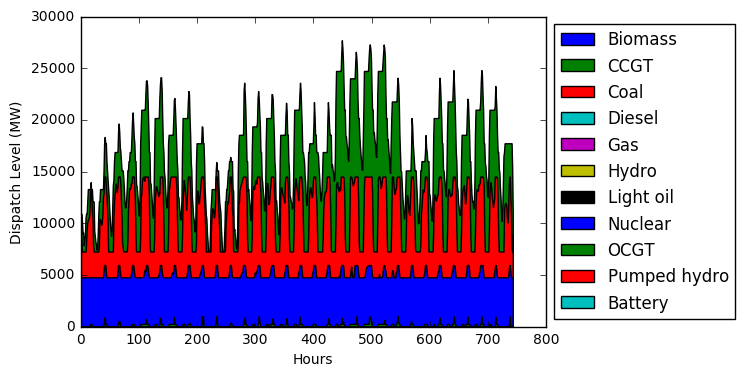

In [116]:
if cluster == 1:
    # Generate subplot for the period of all committed generators
    fig, ax = plt.subplots()
    for i in num_types:
        ax.stackplot(hours[0:25], power_stack[i,0:25])
   
    plt.legend(gen_label, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Hours')
    plt.ylabel('Dispatch Level (MW)')
    plt.show()
    
else:
    fig, ax = plt.subplots()
    for i in num_labels:
        ax.stackplot(hours,  gen_type_summary[i,:])
   
    plt.legend(gen_label, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Hours')
    plt.ylabel('Dispatch Level (MW)')
    plt.show()
    
#fig.savefig('stackplot.png')   # save the figure to file
#plt.close(fig)  

In [117]:
fixed = model.fixed()
fixed.setParam(GRB.Param.QCPDual, 1)
fixed.optimize()
if fixed.status != GRB.status.OPTIMAL:
    print("Error: fixed model isn’t optimal")
    exit(1)
    
diff = model.objVal - fixed.objVal

if abs(diff) > 1e-6 * (1.0 + abs(model.objVal)):
    print("Error: objective values are different")
    exit(1)

    

    


Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 2343950 rows, 1322959 columns and 27596437 nonzeros
Model has 475162 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-01, 2e+04]
  QMatrix range    [1e-01, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 2318696 rows and 1132415 columns (presolve time = 5s) ...
Presolve removed 2318710 rows and 1275455 columns
Presolve time: 5.99s
Presolved: 106877 rows, 47518 columns, 209640 nonzeros
Ordering time: 0.11s

Barrier statistics:
 AA' NZ     : 3.872e+05
 Factor NZ  : 1.772e+06 (roughly 80 MBytes of memory)
 Factor Ops : 6.151e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.90025606e+09  1.26115960e+09  6.06e+03 0.00e+00  1.52e+04     6s
   1   2.14305978

### Extract Shadow Prices

In [133]:
# demand_constr = fixed.getConstrByName("balance")

# print(demand_constr)

# print(demand_constr.pi)

# ref =  np.matlib.zeros((len(hours), 1))
shadow_price_demand =  np.matlib.zeros((len(hours), 1))


count = 0
for hour in hours:
    label = ["balance_"+str(count)]
    label = str(label)
    ref = fixed.getConstrByName(label)
    shadow_price_demand[hour] = ref.pi
    count = count + 1


### Compare shadow price with electricity market price

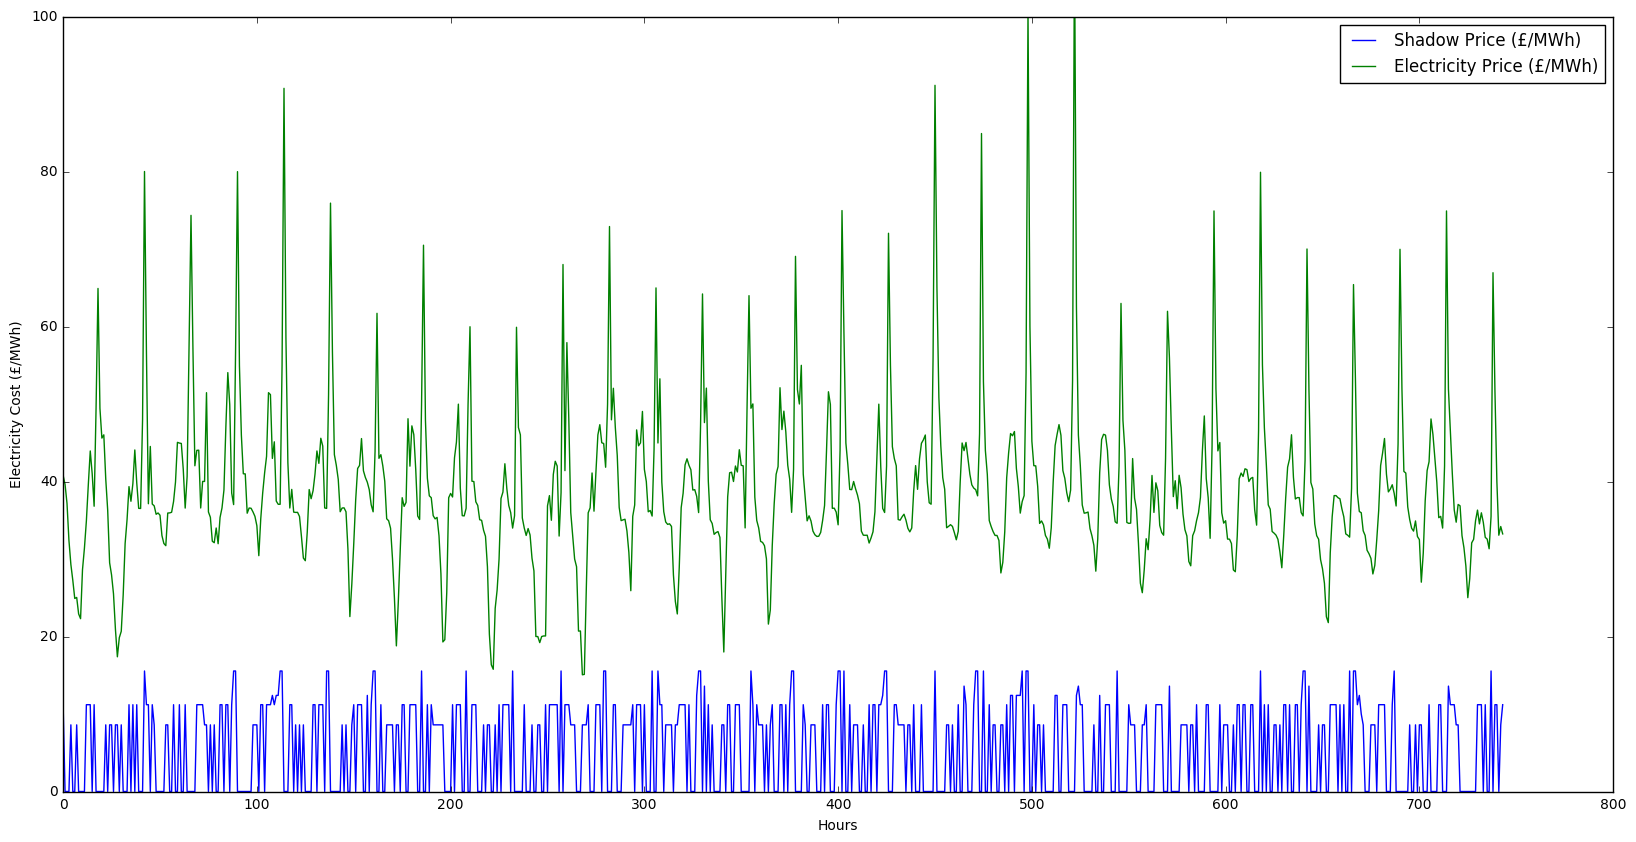

In [134]:
fig = plt.figure(figsize=(20, 10), dpi=100)
plt.plot(hours,shadow_price_demand, 'b', label='Shadow Price (£/MWh)')
plt.plot(hours, price, 'g', label='Electricity Price (£/MWh)')
plt.xlabel('Hours')
plt.ylabel('Electricity Cost (£/MWh)')
plt.ylim((0,100))
plt.legend(loc='best')
fig.savefig('170701_pricecomparison_market_v_shadowprice.png')   # save the figure to file
plt.show()
plt.close(fig)

In [46]:
t1 = time.time()

total = t1-t0

print(total)




807.5630497932434
